<a href="https://colab.research.google.com/github/iremgngr/Machine_Learning/blob/main/NaiveBayes_vs_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

In [25]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
df = pd.read_csv('news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [37]:
# Drop Unnecessary Columns
df = df.drop(columns=['Unnamed: 0', 'title'])
df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


<Axes: >

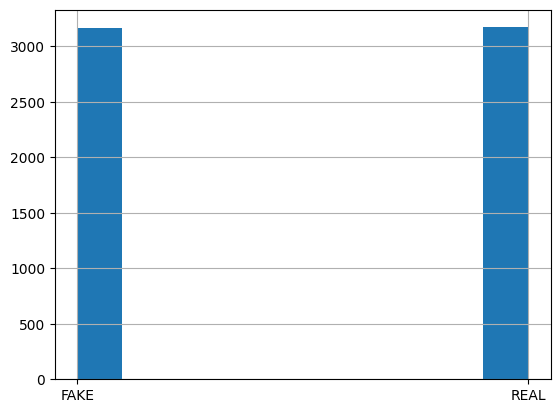

In [29]:
df['label'].hist()

In [38]:
# Create Binary Labels
df['b_labels'] = df['label'].map({'REAL': 0, 'FAKE': 1})
Y = df['b_labels'].to_numpy()
print("New Dataframe: ")
df

New Dataframe: 


,text,label,b_labels
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,1
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,1
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,0
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,1
4,It's primary day in New York and front-runners...,REAL,0
...,...,...,...
6330,The State Department told the Republican Natio...,REAL,0
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE,1
6332,Anti-Trump Protesters Are Tools of the Oligar...,FAKE,1
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",REAL,0


In [39]:
# Lower Casing
df['text'] = df['text'].str.lower()
df

,text,label,b_labels
0,"daniel greenfield, a shillman journalism fello...",FAKE,1
1,google pinterest digg linkedin reddit stumbleu...,FAKE,1
2,u.s. secretary of state john f. kerry said mon...,REAL,0
3,"— kaydee king (@kaydeeking) november 9, 2016 t...",FAKE,1
4,it's primary day in new york and front-runners...,REAL,0
...,...,...,...
6330,the state department told the republican natio...,REAL,0
6331,the ‘p’ in pbs should stand for ‘plutocratic’ ...,FAKE,1
6332,anti-trump protesters are tools of the oligar...,FAKE,1
6333,"addis ababa, ethiopia —president obama convene...",REAL,0


In [41]:
# Removing Punctuation with Regex
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df

,text,label,b_labels
0,daniel greenfield a shillman journalism fellow...,FAKE,1
1,google pinterest digg linkedin reddit stumbleu...,FAKE,1
2,us secretary of state john f kerry said monday...,REAL,0
3,kaydee king kaydeeking november 9 2016 the le...,FAKE,1
4,its primary day in new york and frontrunners h...,REAL,0
...,...,...,...
6330,the state department told the republican natio...,REAL,0
6331,the p in pbs should stand for plutocratic or p...,FAKE,1
6332,antitrump protesters are tools of the oligarc...,FAKE,1
6333,addis ababa ethiopia president obama convened ...,REAL,0


In [42]:
# Removing Numbers
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
df

,text,label,b_labels
0,daniel greenfield a shillman journalism fellow...,FAKE,1
1,google pinterest digg linkedin reddit stumbleu...,FAKE,1
2,us secretary of state john f kerry said monday...,REAL,0
3,kaydee king kaydeeking november the lesson ...,FAKE,1
4,its primary day in new york and frontrunners h...,REAL,0
...,...,...,...
6330,the state department told the republican natio...,REAL,0
6331,the p in pbs should stand for plutocratic or p...,FAKE,1
6332,antitrump protesters are tools of the oligarc...,FAKE,1
6333,addis ababa ethiopia president obama convened ...,REAL,0


In [43]:
# Removing Stopwords
stop = stopwords.words('english')

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df

,text,label,b_labels
0,daniel greenfield shillman journalism fellow f...,FAKE,1
1,google pinterest digg linkedin reddit stumbleu...,FAKE,1
2,us secretary state john f kerry said monday st...,REAL,0
3,kaydee king kaydeeking november lesson tonight...,FAKE,1
4,primary day new york frontrunners hillary clin...,REAL,0
...,...,...,...
6330,state department told republican national comm...,REAL,0
6331,p pbs stand plutocratic pentagon posted oct wi...,FAKE,1
6332,antitrump protesters tools oligarchy reform al...,FAKE,1
6333,addis ababa ethiopia president obama convened ...,REAL,0


In [44]:
# Tokenization
df['text'] = df['text'].apply(word_tokenize)
df

,text,label,b_labels
0,"[daniel, greenfield, shillman, journalism, fel...",FAKE,1
1,"[google, pinterest, digg, linkedin, reddit, st...",FAKE,1
2,"[us, secretary, state, john, f, kerry, said, m...",REAL,0
3,"[kaydee, king, kaydeeking, november, lesson, t...",FAKE,1
4,"[primary, day, new, york, frontrunners, hillar...",REAL,0
...,...,...,...
6330,"[state, department, told, republican, national...",REAL,0
6331,"[p, pbs, stand, plutocratic, pentagon, posted,...",FAKE,1
6332,"[antitrump, protesters, tools, oligarchy, refo...",FAKE,1
6333,"[addis, ababa, ethiopia, president, obama, con...",REAL,0


In [45]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
df

,text,label,b_labels
0,"[daniel, greenfield, shillman, journalism, fel...",FAKE,1
1,"[google, pinterest, digg, linkedin, reddit, st...",FAKE,1
2,"[u, secretary, state, john, f, kerry, said, mo...",REAL,0
3,"[kaydee, king, kaydeeking, november, lesson, t...",FAKE,1
4,"[primary, day, new, york, frontrunners, hillar...",REAL,0
...,...,...,...
6330,"[state, department, told, republican, national...",REAL,0
6331,"[p, pb, stand, plutocratic, pentagon, posted, ...",FAKE,1
6332,"[antitrump, protester, tool, oligarchy, reform...",FAKE,1
6333,"[addis, ababa, ethiopia, president, obama, con...",REAL,0


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
# Convert the text type list to string
df['text'] = df['text'].astype(str)

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['text'])
y = df['b_labels']

In [51]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

In [53]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [57]:
# Evaluation Metrics Function
def evaluate_model(y_true, y_pred, model_name):
    print(f"- {model_name} Performance -")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Evaluate Naive Bayes
evaluate_model(y_test, y_pred_nb, "Naive Bayes")

# Evaluate Logistic Regression
evaluate_model(y_test, y_pred_lr, "Logistic Regression")

- Naive Bayes Performance -
Accuracy: 0.8879
Precision: 0.8738
Recall: 0.9045
F1-Score: 0.8889

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89       639
           1       0.87      0.90      0.89       628

    accuracy                           0.89      1267
   macro avg       0.89      0.89      0.89      1267
weighted avg       0.89      0.89      0.89      1267

- Logistic Regression Performance -
Accuracy: 0.9108
Precision: 0.9005
Recall: 0.9220
F1-Score: 0.9111

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       639
           1       0.90      0.92      0.91       628

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267



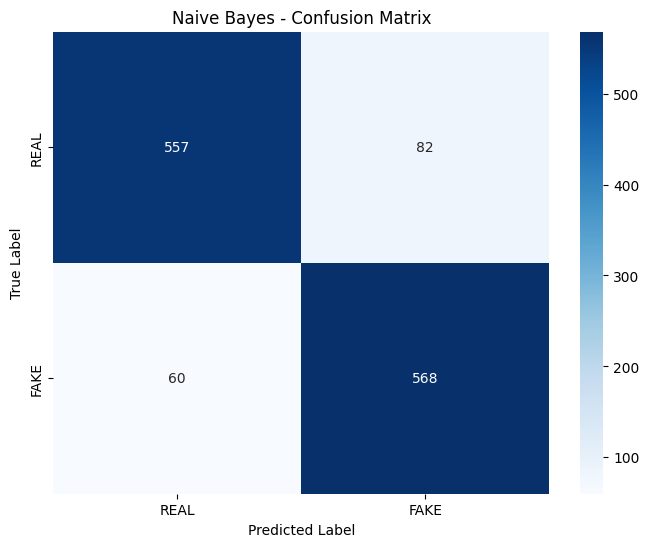

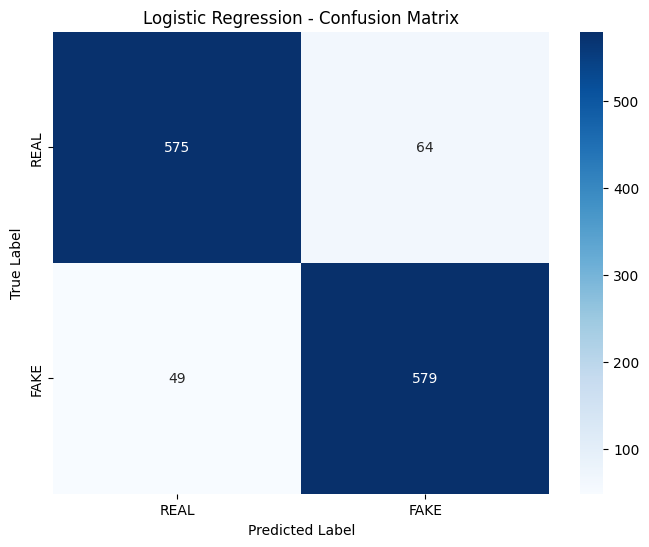

In [60]:
# Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Confusion Matrix for Naive Bayes
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")

# Confusion Matrix for Logistic Regression
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")